# détection d'intrusions réseau en utilisant un classificateur Multi-Layer Perceptron (MLP)
## Classification d'intrusions réseau avec le dataset NSL-KDD
Ce notebook présente une analyse complète de détection d'intrusions réseau en utilisant un classificateur Multi-Layer Perceptron (MLP) sur le dataset NSL-KDD.
Objectifs

Détecter et classifier différents types d'attaques réseau
Évaluer les performances du modèle MLP
Analyser les métriques de sécurité

1. Importation des bibliothèques

In [1]:
# --------------------- importing libraries ---------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ---------------- importing class for label encoding ------------

from sklearn.preprocessing import LabelEncoder

# --------- importing method to split the dataset -------------------

from sklearn.model_selection import train_test_split

# ------------- importing class for feature scaling --------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------ importing class for cross validation --------------

from sklearn.model_selection import StratifiedKFold

# ------------ importing MLP classifier ----------

from sklearn.neural_network import MLPClassifier

# ----------- importing methods for performance evaluation ------------

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

2. Chargement des données

In [2]:
# --------------------- importing dataset -----------------------

try:
    train_dataset = pd.read_csv('NSL-KDD__Multiclass_Classification_Dataset.csv')
    test_dataset = pd.read_csv('KDDTest+.csv')
    print("✅ Datasets chargés avec succès!")
    print(f"📊 Shape du dataset d'entraînement: {train_dataset.shape}")
    print(f"📊 Shape du dataset de test: {test_dataset.shape}")
except FileNotFoundError as e:
    print(f"❌ Erreur lors du chargement des datasets: {e}")
    print("⚠️  Assurez-vous que les fichiers CSV sont dans le bon répertoire")
    exit()

# Aperçu des données
print("\n🔍 Aperçu du dataset d'entraînement:")
print(train_dataset.head())

print("\n📋 Informations sur le dataset:")
print(train_dataset.info())

✅ Datasets chargés avec succès!
📊 Shape du dataset d'entraînement: (4047, 43)
📊 Shape du dataset de test: (22544, 43)

🔍 Aperçu du dataset d'entraînement:
   duration protocol_type    service flag  src_bytes  dst_bytes  land  \
0         0           tcp        ftp   S0          0          0     0   
1         0           tcp   http_443   S0          0          0     0   
2         0           tcp  uucp_path   S0          0          0     0   
3         0           tcp    private   S0          0          0     0   
4         0           tcp    private   S0          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.07   
1               0       0    0  ...                    0.07   
2               0       0    0  ...                    0.07   
3               0       0    0  ...                    0.04   
4               0       0    0  ...                    0.09   

   dst_host_diff_srv_rate  

3. Nettoyage des données

In [3]:
# -------------------- taking care of inconsistent data -----------------

print("\n🧹 --- Nettoyage des données ---")

# Dataset d'entraînement
train_dataset = train_dataset.replace([np.inf, -np.inf], np.nan) 
train_dataset = train_dataset.dropna()
train_dataset = train_dataset.drop_duplicates()
print(f'📊 Training set - Nombre de valeurs nulles : {train_dataset.isnull().sum().sum()}')

# Dataset de test
test_dataset = test_dataset.replace([np.inf, -np.inf], np.nan) 
test_dataset = test_dataset.dropna()
test_dataset = test_dataset.drop_duplicates()
print(f'📊 Test set - Nombre de valeurs nulles : {test_dataset.isnull().sum().sum()}')

print(f"✅ Après nettoyage:")
print(f"   - Dataset d'entraînement: {train_dataset.shape}")
print(f"   - Dataset de test: {test_dataset.shape}")


🧹 --- Nettoyage des données ---
📊 Training set - Nombre de valeurs nulles : 0
📊 Test set - Nombre de valeurs nulles : 0
✅ Après nettoyage:
   - Dataset d'entraînement: (4047, 43)
   - Dataset de test: (22544, 43)


4. Standardisation des catégories d'attaques

In [4]:
# --------------- generalising different types of attacks in test set --------------------------

print("\n🎯 --- Standardisation des catégories d'attaques ---")

# Définition des catégories d'attaques
DoS = ['apache2','mailbomb','neptune','teardrop','smurf','pod','back','land','processtable']
test_dataset = test_dataset.replace(to_replace = DoS, value = 'DoS')

U2R = ['httptunnel','ps','xterm','sqlattack','rootkit','buffer_overflow','loadmodule','perl']
test_dataset = test_dataset.replace(to_replace = U2R, value = 'U2R')

R2L = ['udpstorm','worm','snmpgetattack','sendmail','named','snmpguess','xsnoop','xlock',
       'warezclient','guess_passwd','ftp_write','multihop','imap','phf','warezmaster','spy']
test_dataset = test_dataset.replace(to_replace = R2L, value = 'R2L')

Probe = ['mscan','saint','ipsweep','portsweep','nmap','satan']
test_dataset = test_dataset.replace(to_replace = Probe, value = 'Probe')

print("✅ Catégories d'attaques standardisées:")
print("   🔴 DoS (Denial of Service)")
print("   🟠 U2R (User to Root)")
print("   🟡 R2L (Remote to Local)")
print("   🟢 Probe (Probing)")
print("   🔵 Normal (Trafic normal)")


🎯 --- Standardisation des catégories d'attaques ---
✅ Catégories d'attaques standardisées:
   🔴 DoS (Denial of Service)
   🟠 U2R (User to Root)
   🟡 R2L (Remote to Local)
   🟢 Probe (Probing)
   🔵 Normal (Trafic normal)


5. Analyse exploratoire des données


📊 Distribution des classes dans le dataset d'entraînement:
   DoS: 1,000 (24.71%)
   Probe: 1,000 (24.71%)
   R2L: 995 (24.59%)
   U2R: 52 (1.28%)
   normal: 1,000 (24.71%)

📊 Distribution des classes dans le dataset de test:
   DoS: 7,456 (33.07%)
   Probe: 2,421 (10.74%)
   R2L: 2,756 (12.22%)
   U2R: 200 (0.89%)
   normal: 9,711 (43.08%)


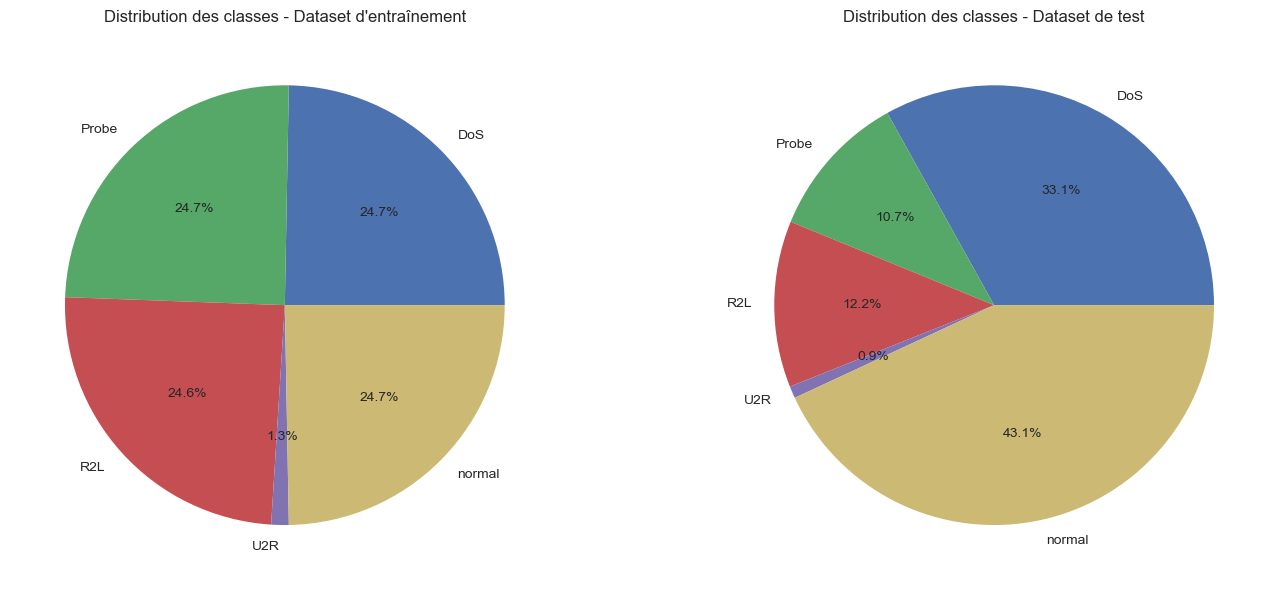

In [5]:
# --------------- creating dependent variable vector ----------------

y_train = train_dataset.iloc[:, -2].values
y_test = test_dataset.iloc[:, -2].values

print("\n📊 Distribution des classes dans le dataset d'entraînement:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_distribution = pd.DataFrame({'Classe': unique_train, 'Nombre': counts_train})
train_distribution['Proportion'] = train_distribution['Nombre'] / train_distribution['Nombre'].sum() * 100

for idx, row in train_distribution.iterrows():
    print(f"   {row['Classe']}: {row['Nombre']:,} ({row['Proportion']:.2f}%)")

print("\n📊 Distribution des classes dans le dataset de test:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
test_distribution = pd.DataFrame({'Classe': unique_test, 'Nombre': counts_test})
test_distribution['Proportion'] = test_distribution['Nombre'] / test_distribution['Nombre'].sum() * 100

for idx, row in test_distribution.iterrows():
    print(f"   {row['Classe']}: {row['Nombre']:,} ({row['Proportion']:.2f}%)")

# Visualisation de la distribution des classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dataset d'entraînement
ax1.pie(train_distribution['Nombre'], labels=train_distribution['Classe'], autopct='%1.1f%%')
ax1.set_title('Distribution des classes - Dataset d\'entraînement')

# Dataset de test
ax2.pie(test_distribution['Nombre'], labels=test_distribution['Classe'], autopct='%1.1f%%')
ax2.set_title('Distribution des classes - Dataset de test')

plt.tight_layout()
plt.show()

6. Préparation des données

In [6]:
# --------------- onehotencoding the categorical variables with dummy variables ----------------

print("\n🔄 --- One-Hot Encoding ---")

# Suppression des colonnes de classe et difficulty
train_dataset.drop(train_dataset.iloc[:, [41, 42]], inplace = True, axis = 1) 
train_dataset = pd.get_dummies(train_dataset)

test_dataset.drop(test_dataset.iloc[:, [41, 42]], inplace = True, axis = 1) 
test_dataset = pd.get_dummies(test_dataset)

print(f"📊 Après encodage - Caractéristiques d'entraînement: {train_dataset.shape[1]}")
print(f"📊 Après encodage - Caractéristiques de test: {test_dataset.shape[1]}")

# ----- inserting columns of zeroes for categorical variables that are not common in train & test set -------

# Obtenir les noms de colonnes pour vérifier lesquelles existent
train_cols = set(train_dataset.columns)
test_cols = set(test_dataset.columns)

# Ajouter les colonnes manquantes pour rendre les datasets compatibles
missing_in_train = test_cols - train_cols
missing_in_test = train_cols - test_cols

print(f"📊 Colonnes manquantes dans train: {len(missing_in_train)}")
print(f"📊 Colonnes manquantes dans test: {len(missing_in_test)}")

for col in missing_in_train:
    train_dataset[col] = 0

for col in missing_in_test:
    test_dataset[col] = 0

# S'assurer du même ordre des colonnes
train_dataset = train_dataset.reindex(sorted(train_dataset.columns), axis=1)
test_dataset = test_dataset.reindex(sorted(test_dataset.columns), axis=1)

print(f"✅ Final - Caractéristiques d'entraînement: {train_dataset.shape[1]}")
print(f"✅ Final - Caractéristiques de test: {test_dataset.shape[1]}")

# ----------------- creating matrix of features ----------------

X_train = train_dataset.iloc[:, :].values
X_test = test_dataset.iloc[:, :].values

print(f"📊 Matrice des caractéristiques créée:")
print(f"   - X_train shape: {X_train.shape}")
print(f"   - X_test shape: {X_test.shape}")


🔄 --- One-Hot Encoding ---
📊 Après encodage - Caractéristiques d'entraînement: 109
📊 Après encodage - Caractéristiques de test: 116
📊 Colonnes manquantes dans train: 7
📊 Colonnes manquantes dans test: 0
✅ Final - Caractéristiques d'entraînement: 116
✅ Final - Caractéristiques de test: 116
📊 Matrice des caractéristiques créée:
   - X_train shape: (4047, 116)
   - X_test shape: (22544, 116)


7. Encodage des labels et normalisation

In [7]:
# -------------- encoding categorical (dependent) variable -----------------

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print("\n🏷️ Après encodage des labels:")
print("📊 Distribution des classes d'entraînement:", 
      dict(zip(*np.unique(y_train, return_counts=True))))
print("📊 Distribution des classes de test:", 
      dict(zip(*np.unique(y_test, return_counts=True))))

# Stocker les noms des classes pour référence ultérieure
class_names = le.classes_
print("\n🗂️ Mapping des classes:")
for i, name in enumerate(class_names):
    print(f"   {i}: {name}")

# --------------------------- feature scaling --------------------------------

print("\n⚖️ --- Normalisation des caractéristiques ---")
# MLP est sensible à la normalisation des caractéristiques, donc on utilise StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Normalisation des caractéristiques terminée!")
print(f"📊 Moyenne des caractéristiques après normalisation: {np.mean(X_train):.6f}")
print(f"📊 Écart-type des caractéristiques après normalisation: {np.std(X_train):.6f}")


🏷️ Après encodage des labels:
📊 Distribution des classes d'entraînement: {0: 1000, 1: 1000, 2: 995, 3: 52, 4: 1000}
📊 Distribution des classes de test: {0: 7456, 1: 2421, 2: 2756, 3: 200, 4: 9711}

🗂️ Mapping des classes:
   0: DoS
   1: Probe
   2: R2L
   3: U2R
   4: normal

⚖️ --- Normalisation des caractéristiques ---
✅ Normalisation des caractéristiques terminée!
📊 Moyenne des caractéristiques après normalisation: -0.000000
📊 Écart-type des caractéristiques après normalisation: 0.960424


8. Configuration du modèle MLP

In [8]:
# ---------------------- Define MLP classifier ---------------------------

print("\n🧠 --- Configuration du classificateur MLP ---")

# Configuration MLP avec paramètres optimisés
classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),  # Trois couches cachées avec diminution des neurones
    activation='relu',                  # Fonction d'activation ReLU
    solver='adam',                     # Optimiseur Adam pour convergence plus rapide
    alpha=0.001,                       # Paramètre de pénalité L2 (régularisation)
    batch_size='auto',                 # Taille des mini-batches pour optimiseurs stochastiques
    learning_rate='adaptive',          # Planification du taux d'apprentissage
    learning_rate_init=0.001,          # Taux d'apprentissage initial
    max_iter=500,                      # Nombre maximum d'itérations
    shuffle=True,                      # Mélanger les échantillons à chaque itération
    random_state=42,                   # État aléatoire pour reproductibilité
    tol=1e-4,                         # Tolérance pour l'optimisation
    verbose=False,                     # Afficher le progrès
    warm_start=False,                  # Réutiliser la solution précédente
    momentum=0.9,                      # Momentum pour la descente de gradient
    nesterovs_momentum=True,           # Utiliser le momentum de Nesterov
    early_stopping=True,               # Utiliser l'arrêt précoce
    validation_fraction=0.1,           # Fraction des données d'entraînement pour l'arrêt précoce
    beta_1=0.9,                       # Taux de décroissance exponentielle pour les estimations du premier moment
    beta_2=0.999,                     # Taux de décroissance exponentielle pour les estimations du second moment
    epsilon=1e-8,                     # Valeur pour la stabilité numérique
    n_iter_no_change=10,              # Nombre maximum d'époques sans amélioration de la tolérance
    max_fun=15000                     # Nombre maximum d'appels de fonction de perte
)

print(f"🔧 Configuration du classificateur MLP:")
print(f"   🧠 Couches cachées: {classifier.hidden_layer_sizes}")
print(f"   ⚡ Fonction d'activation: {classifier.activation}")
print(f"   🎯 Optimiseur: {classifier.solver}")
print(f"   📈 Taux d'apprentissage: {classifier.learning_rate}")
print(f"   🛡️ Alpha (pénalité L2): {classifier.alpha}")
print(f"   🔄 Arrêt précoce: {classifier.early_stopping}")


🧠 --- Configuration du classificateur MLP ---
🔧 Configuration du classificateur MLP:
   🧠 Couches cachées: (100, 50, 25)
   ⚡ Fonction d'activation: relu
   🎯 Optimiseur: adam
   📈 Taux d'apprentissage: adaptive
   🛡️ Alpha (pénalité L2): 0.001
   🔄 Arrêt précoce: True


9. Validation croisée stratifiée


In [9]:
# ---------------------- stratified k fold ---------------------------

print("\n🔀 --- Validation Croisée Stratifiée ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisation des listes pour stocker les métriques
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
true_negative_rates = []
false_positive_rates = []
false_negative_rates = []
false_alarm_rates = []

fold = 1
print("🎯 Début de la validation croisée...")

for train, test in cv.split(X_train, y_train):
    print(f"\n📊 Traitement du fold {fold}/5...")
    
    # ------------------------ splitting the train set into NEW train set and validation set ------------------------
    X_train_fold, X_validation = X_train[train], X_train[test]
    y_train_fold, y_validation = y_train[train], y_train[test]
    
    print(f"   📊 Taille du fold d'entraînement: {X_train_fold.shape[0]}")
    print(f"   📊 Taille du fold de validation: {X_validation.shape[0]}")
    
    # ------------------ fitting the MLP classifier to the NEW train set ------------------------
    print(f"   🧠 Entraînement du MLP sur le fold {fold}...")
    classifier.fit(X_train_fold, y_train_fold)
    print(f"   ✅ Entraînement terminé. Itérations: {classifier.n_iter_}")
    
    # --------------------- predicting the validation set result ------------------------
    y_pred = classifier.predict(X_validation)
    
    # ------------------------ performance evaluation using methods from scikit learn --------------------------------
    accuracy_scores.append(accuracy_score(y_validation, y_pred))
    precision_scores.append(np.mean(precision_score(y_validation, y_pred, average=None, zero_division=0)))
    recall_scores.append(np.mean(recall_score(y_validation, y_pred, average=None, zero_division=0)))
    f1_scores.append(np.mean(f1_score(y_validation, y_pred, average=None, zero_division=0)))
    
    # ---------------------- making confusion matrix -----------------------------
    cm = multilabel_confusion_matrix(y_validation, y_pred)
    
    # --------------------- performance evaluation using the confusion matrix ---------------
    TNR = []
    FPR = []
    FNR = []
    FAR = []
    
    for i in range(len(class_names)):
        if i < len(cm):
            tn = cm[i][0][0]
            fn = cm[i][1][0]
            tp = cm[i][1][1]
            fp = cm[i][0][1]
            
            # Éviter la division par zéro
            if (fp + tn) > 0:
                TNR.append(tn / (fp + tn))
                FPR.append(fp / (fp + tn))
            else:
                TNR.append(0)
                FPR.append(0)
                
            if (fn + tp) > 0:
                FNR.append(fn / (fn + tp))
            else:
                FNR.append(0)
                
            if (fp + fn + tp + tn) > 0:
                FAR.append((fp + fn) / (fp + fn + tp + tn))
            else:
                FAR.append(0)

    # ------------- getting average values (of all classes) for each fold ----------------    
    true_negative_rates.append(np.mean(TNR))
    false_positive_rates.append(np.mean(FPR))
    false_negative_rates.append(np.mean(FNR))
    false_alarm_rates.append(np.mean(FAR))
    
    print(f"   📈 Accuracy du fold {fold}: {accuracy_scores[-1]:.4f}")
    fold += 1

print("\n✅ Validation croisée terminée!")


🔀 --- Validation Croisée Stratifiée ---
🎯 Début de la validation croisée...

📊 Traitement du fold 1/5...
   📊 Taille du fold d'entraînement: 3237
   📊 Taille du fold de validation: 810
   🧠 Entraînement du MLP sur le fold 1...
   ✅ Entraînement terminé. Itérations: 24
   📈 Accuracy du fold 1: 0.9568

📊 Traitement du fold 2/5...
   📊 Taille du fold d'entraînement: 3237
   📊 Taille du fold de validation: 810
   🧠 Entraînement du MLP sur le fold 2...
   ✅ Entraînement terminé. Itérations: 23
   📈 Accuracy du fold 2: 0.9605

📊 Traitement du fold 3/5...
   📊 Taille du fold d'entraînement: 3238
   📊 Taille du fold de validation: 809
   🧠 Entraînement du MLP sur le fold 3...
   ✅ Entraînement terminé. Itérations: 34
   📈 Accuracy du fold 3: 0.9642

📊 Traitement du fold 4/5...
   📊 Taille du fold d'entraînement: 3238
   📊 Taille du fold de validation: 809
   🧠 Entraînement du MLP sur le fold 4...
   ✅ Entraînement terminé. Itérations: 22
   📈 Accuracy du fold 4: 0.9555

📊 Traitement du fold 5

10. Résultats de la validation croisée


🎯 ================== Résultats MLP - Validation Croisée =====================
📊 Accuracy Score : 0.9610 ± 0.0046
🎯 Precision Score : 0.9392 ± 0.0285
🔍 Recall Score : 0.8922 ± 0.0313
⚖️ F1 Score : 0.9108 ± 0.0315
✅ Spécificité (TNR) : 0.9897 ± 0.0012
❌ Taux de Faux Positifs : 0.0103 ± 0.0012
⚠️ Taux de Faux Négatifs : 0.1078 ± 0.0313
🚨 Taux de Fausse Alarme : 0.0156 ± 0.0018


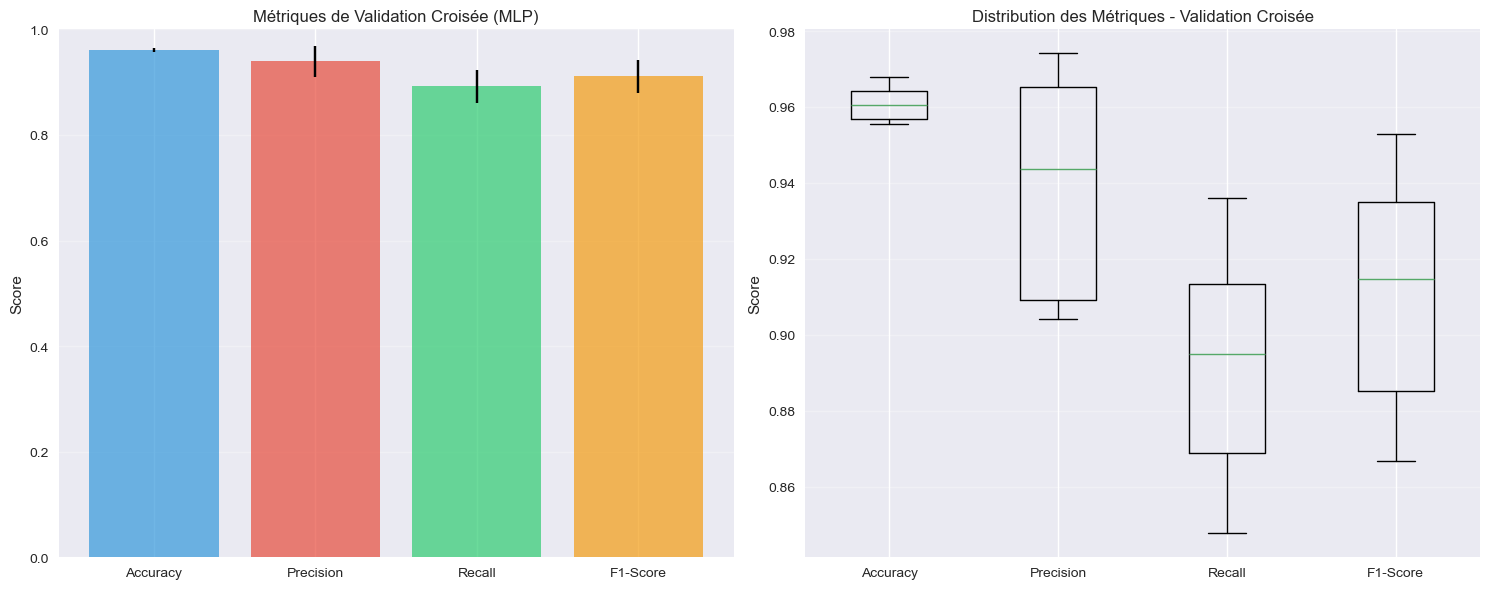

In [10]:
# ------------------------ printing results of performance evaluation -------------------

print('\n🎯 ================== Résultats MLP - Validation Croisée =====================')
print(f'📊 Accuracy Score : {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}')
print(f'🎯 Precision Score : {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}')
print(f'🔍 Recall Score : {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}')
print(f'⚖️ F1 Score : {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}') 
print(f'✅ Spécificité (TNR) : {np.mean(true_negative_rates):.4f} ± {np.std(true_negative_rates):.4f}')
print(f'❌ Taux de Faux Positifs : {np.mean(false_positive_rates):.4f} ± {np.std(false_positive_rates):.4f}')
print(f'⚠️ Taux de Faux Négatifs : {np.mean(false_negative_rates):.4f} ± {np.std(false_negative_rates):.4f}')
print(f'🚨 Taux de Fausse Alarme : {np.mean(false_alarm_rates):.4f} ± {np.std(false_alarm_rates):.4f}')   

# Visualisation des métriques de validation croisée
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy_scores, precision_scores, recall_scores, f1_scores]
metrics_std = [np.std(scores) for scores in metrics_values]
metrics_mean = [np.mean(scores) for scores in metrics_values]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique en barres avec barres d'erreur
ax1.bar(metrics_names, metrics_mean, yerr=metrics_std, capsize=5, 
        color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], alpha=0.7)
ax1.set_title('Métriques de Validation Croisée (MLP)')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Box plot pour montrer la distribution
ax2.boxplot(metrics_values, labels=metrics_names)
ax2.set_title('Distribution des Métriques - Validation Croisée')
ax2.set_ylabel('Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

11. Entraînement du modèle final et test

In [11]:
# ------------------ Train final model on full training set and predict test set --------------------

print("\n🚀 --- Entraînement du Modèle MLP Final ---")
print("🧠 Entraînement du MLP sur l'ensemble complet d'entraînement...")

classifier.fit(X_train, y_train)
print(f"✅ Entraînement terminé. Itérations totales: {classifier.n_iter_}")
print(f"📉 Perte finale: {classifier.loss_:.6f}")

print("\n🔮 Prédiction sur le dataset de test...")
y_pred = classifier.predict(X_test)

# --------------- making confusion matrix -----------------

cm = multilabel_confusion_matrix(y_test, y_pred)

# ---------------- performance evaluation using confusion matrix -----------------

TNR = []
FPR = []
FNR = []
FAR = []

for i in range(len(class_names)):    
    if i < len(cm):
        tn = cm[i][0][0]
        fn = cm[i][1][0]
        tp = cm[i][1][1]
        fp = cm[i][0][1]
        
        # Éviter la division par zéro
        if (fp + tn) > 0:
            TNR.append(tn / (fp + tn))
            FPR.append(fp / (fp + tn))
        else:
            TNR.append(0)
            FPR.append(0)
            
        if (fn + tp) > 0:
            FNR.append(fn / (fn + tp))
        else:
            FNR.append(0)
            
        if (fp + fn + tp + tn) > 0:
            FAR.append((fp + fn) / (fp + fn + tp + tn))
        else:
            FAR.append(0)


🚀 --- Entraînement du Modèle MLP Final ---
🧠 Entraînement du MLP sur l'ensemble complet d'entraînement...
✅ Entraînement terminé. Itérations totales: 31
📉 Perte finale: 0.037208

🔮 Prédiction sur le dataset de test...


12. Résultats finaux sur le dataset de test

In [12]:
# --------------- printing results of performance evaluation --------------------

print('\n🎯 ================ Résultats MLP - Dataset de Test ================')
print(f'📊 Accuracy Score : {accuracy_score(y_test, y_pred):.4f}')
print(f'🎯 Precision Score : {np.mean(precision_score(y_test, y_pred, average=None, zero_division=0)):.4f}')
print(f'🔍 Recall Score : {np.mean(recall_score(y_test, y_pred, average=None, zero_division=0)):.4f}')
print(f'⚖️ F1 Score : {np.mean(f1_score(y_test, y_pred, average=None, zero_division=0)):.4f}')
print(f'✅ Spécificité (TNR) : {np.mean(TNR):.4f}')
print(f'❌ Taux de Faux Positifs : {np.mean(FPR):.4f}')
print(f'⚠️ Taux de Faux Négatifs : {np.mean(FNR):.4f}')
print(f'🚨 Taux de Fausse Alarme : {np.mean(FAR):.4f}')

# --------------- Detailed classification report --------------------

print('\n📋 ================ Rapport de Classification Détaillé ================')
print(classification_report(y_test, y_pred, target_names=class_names))

# --------------- Per-class metrics --------------------

print('\n📊 ================ Métriques par Classe ================')
precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)

for i, class_name in enumerate(class_names):
    if i < len(precision_per_class):
        print(f"🏷️ {class_name}:")
        print(f"   🎯 Precision: {precision_per_class[i]:.4f}")
        print(f"   🔍 Recall: {recall_per_class[i]:.4f}")
        print(f"   ⚖️ F1-Score: {f1_per_class[i]:.4f}")
        if i < len(TNR):
            print(f"   ✅ Spécificité: {TNR[i]:.4f}")
        print()


🎯 ================ Résultats MLP - Dataset de Test ================
📊 Accuracy Score : 0.7873
🎯 Precision Score : 0.6479
🔍 Recall Score : 0.6056
⚖️ F1 Score : 0.6139
✅ Spécificité (TNR) : 0.9343
❌ Taux de Faux Positifs : 0.0657
⚠️ Taux de Faux Négatifs : 0.3944
🚨 Taux de Fausse Alarme : 0.0851

📋 ================ Rapport de Classification Détaillé ================
              precision    recall  f1-score   support

         DoS       0.91      0.81      0.85      7456
       Probe       0.74      0.80      0.77      2421
         R2L       0.65      0.33      0.44      2756
         U2R       0.18      0.18      0.18       200
      normal       0.76      0.91      0.83      9711

    accuracy                           0.79     22544
   macro avg       0.65      0.61      0.61     22544
weighted avg       0.79      0.79      0.78     22544


📊 ================ Métriques par Classe ================
🏷️ DoS:
   🎯 Precision: 0.9069
   🔍 Recall: 0.8062
   ⚖️ F1-Score: 0.8536
   ✅ Spécif

13. Visualisations avancées

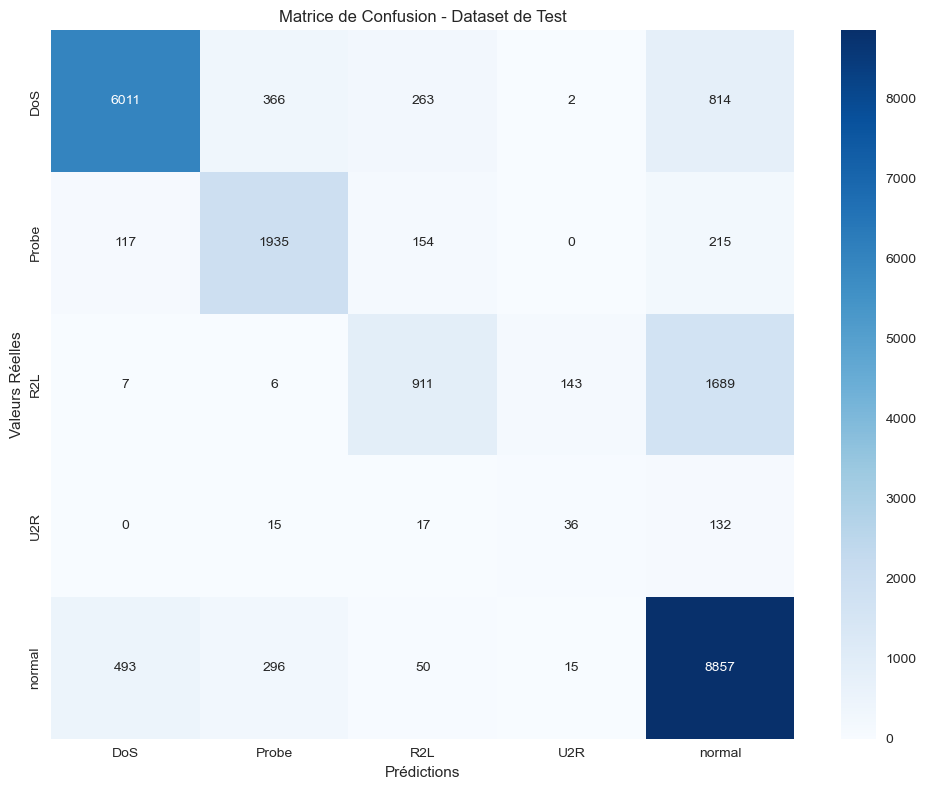

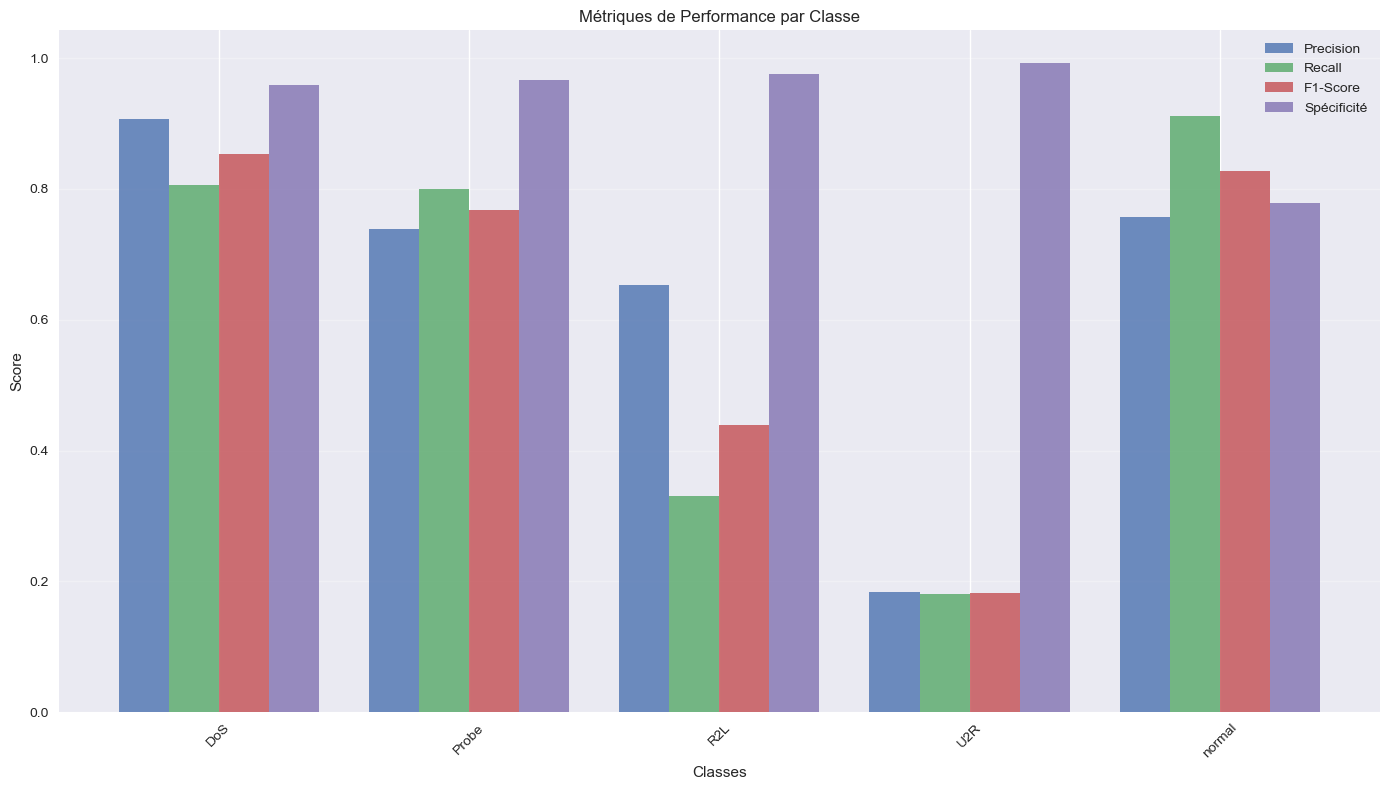

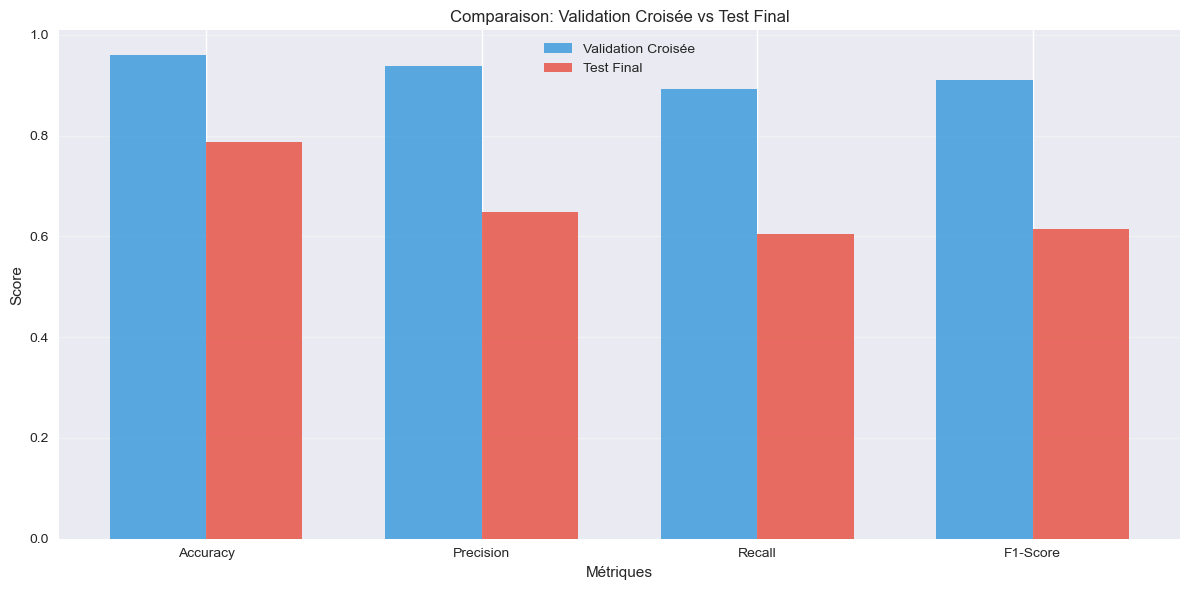

In [13]:
# Matrice de confusion globale
cm_global = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Dataset de Test')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.tight_layout()
plt.show()

# Comparaison des métriques par classe
metrics_df = pd.DataFrame({
    'Classe': class_names,
    'Precision': precision_per_class[:len(class_names)],
    'Recall': recall_per_class[:len(class_names)],
    'F1-Score': f1_per_class[:len(class_names)],
    'Spécificité': TNR[:len(class_names)]
})

# Graphique en barres groupées
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(class_names))
width = 0.2

ax.bar(x - 1.5*width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x - 0.5*width, metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + 0.5*width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x + 1.5*width, metrics_df['Spécificité'], width, label='Spécificité', alpha=0.8)

ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Métriques de Performance par Classe')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Comparaison validation croisée vs test final
comparison_data = {
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Validation Croisée': [np.mean(accuracy_scores), np.mean(precision_scores), 
                          np.mean(recall_scores), np.mean(f1_scores)],
    'Test Final': [accuracy_score(y_test, y_pred),
                   np.mean(precision_score(y_test, y_pred, average=None, zero_division=0)),
                   np.mean(recall_score(y_test, y_pred, average=None, zero_division=0)),
                   np.mean(f1_score(y_test, y_pred, average=None, zero_division=0))]
}

comparison_df = pd.DataFrame(comparison_data)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Validation Croisée'], width, 
       label='Validation Croisée', alpha=0.8, color='#3498db')
ax.bar(x + width/2, comparison_df['Test Final'], width, 
       label='Test Final', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Métriques')
ax.set_ylabel('Score')
ax.set_title('Comparaison: Validation Croisée vs Test Final')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrique'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

14. Informations du modèle MLP


================ MLP Model Information ================
Number of layers: 5
Number of outputs: 5
Classes: [0 1 2 3 4]
Loss function: log_loss
Final loss: 0.037208


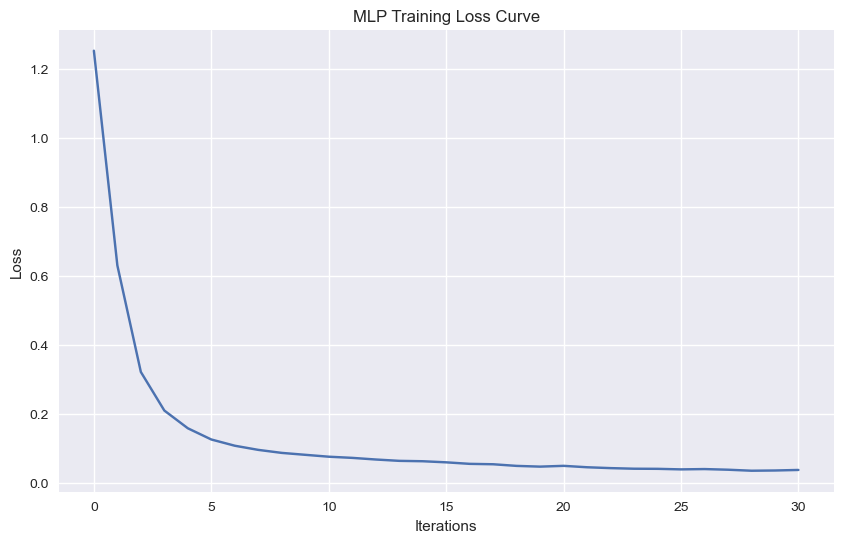

Training loss curve plotted.
MLP model training and evaluation completed successfully!


In [14]:
print('\n================ MLP Model Information ================')
print(f"Number of layers: {classifier.n_layers_}")
print(f"Number of outputs: {classifier.n_outputs_}")
print(f"Classes: {classifier.classes_}")
print(f"Loss function: {classifier.loss}")
print(f"Final loss: {classifier.loss_:.6f}")

# Plot training loss curve if available
try:
    if hasattr(classifier, 'loss_curve_'):
        plt.figure(figsize=(10, 6))
        plt.plot(classifier.loss_curve_)
        plt.title('MLP Training Loss Curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
        print("Training loss curve plotted.")
except Exception as e:
    print(f"Could not plot training curve: {e}")

print("MLP model training and evaluation completed successfully!")